小知識：第一次執行程式時會花較多的時間，因為它要把套件從電腦的硬碟，就是存套件的地方（虛擬環境 statcomp）拉到電腦的 RAM 裡，
然後第二次執行的時候，它就直接在 RAM 裡執行了，所以用的時間會比第一次少很多

算積分

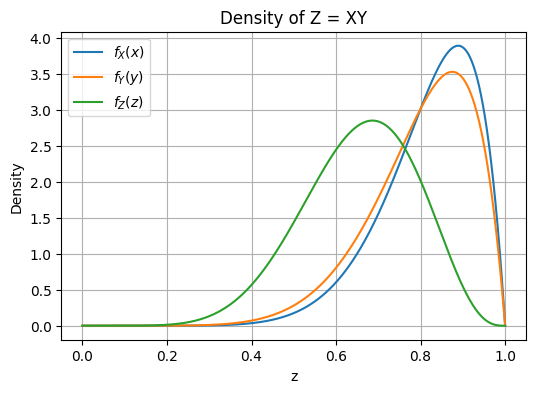

In [14]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

a1, b1, a2, b2 = 9, 2, 8, 2
fx = lambda x: beta.pdf(x, a1, b1)
fy = lambda y: beta.pdf(y, a2, b2)

z = np.linspace(0, 1, 1000)
fz = np.zeros(len(z))
for i in range(len(z)):
    integrand = lambda y: fy(y) * fx(z[i] / y) / y
    fz[i] = integrate.quad(integrand, z[i], 1)[0]  # quad 的方法不是理論的積分方法，它是數值積分方法

fig = plt.figure(figsize=(6, 4))
plt.plot(z, fx(z), label='$f_X(x)$')
plt.plot(z, fy(z), label='$f_Y(y)$')
plt.plot(z, fz, label='$f_Z(z)$')
plt.xlabel('z')
plt.ylabel('Density')
plt.title('Density of Z = XY')
plt.grid()
plt.legend()
plt.show()

c:\Users\Sheng\.vscode\env\statcomp\Lib\site-packages\scipy\optimize\_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


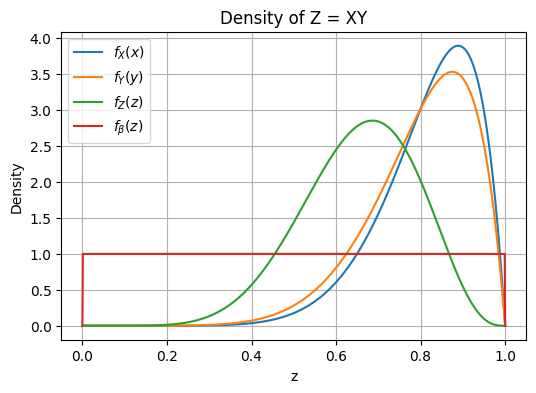

In [14]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate

a1, b1, a2, b2 = 9, 2, 8, 2
fx = lambda x: beta.pdf(x, a1, b1)
fy = lambda y: beta.pdf(y, a2, b2)

z = np.linspace(0, 1, 1000)
# fz = np.zeros(len(z))
# for i in range(len(z)):
#     integrand = lambda y: fy(y) * fx(z[i] / y) / y
#     fz[i] = integrate.quad(integrand, z[i], 1)[0]  # quad 的方法不是理論的積分方法，它是數值積分方法

def f(z):
    fxy = lambda y : fy(y) * fx(z/y) / y  # define the integrand: inline
    tmp = integrate.quad(fxy, z, 1)
    return tmp[0]
fz = np.vectorize(f)(z)  # z 如果是 array，就會自動對每個元素呼叫 f，並且返回一個 array

# 用另一個貝他分配 \beta(a,b) 來近似 Z 的分配，用多變量函數最小值來做
# \min_{a,b} \int (f_Z(z) - f_{\beta}(z; a, b))^2 dz

from scipy.optimize import minimize

def loss(ab):
    a, b = ab
    fz_hat = beta.pdf(z, a, b)
    return np.sum((fz - fz_hat)**2)

res = minimize(loss, [1, 1])
a_hat, b_hat = res.x

fig = plt.figure(figsize=(6, 4))
plt.plot(z, fx(z), label='$f_X(x)$')
plt.plot(z, fy(z), label='$f_Y(y)$')
plt.plot(z, fz, label='$f_Z(z)$')
plt.plot(z, beta.pdf(z, a_hat, b_hat), label='$f_{\\beta}(z)$')
plt.xlabel('z')
plt.ylabel('Density')
plt.title('Density of Z = XY')
plt.grid()
plt.legend()
plt.show()

7.79922584050017 4.135299565574909


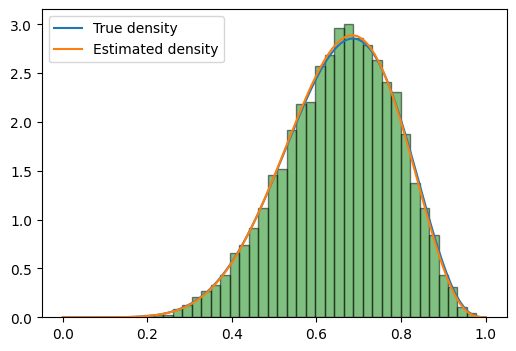

In [ ]:
# simulate the samples of fz
fx = lambda x: beta.pdf(x, a1, b1)
fy = lambda y: beta.pdf(y, a2, b2)

a1, b1, a2, b2 = 9, 2, 8, 2
n = 10000
x = beta.rvs(a1, b1, size = n)
y = beta.rvs(a2, b2, size = n)
Z = x * y

# 用 Z 估計出 beta 分佈的參數
a3, b3, _, _ = beta.fit(Z, floc = 0, fscale = 1)
print(a3, b3)

z = np.linspace(0, 1, 100)
def f(z):
    fxy = lambda y : fy(y) * fx(z/y) / y  # define the integrand: inline
    tmp = integrate.quad(fxy, z, 1)
    return tmp[0]
fz = np.vectorize(f)(z)

# f = lambda x: fz - beta.pdf()

fig = plt.figure(figsize = (6, 4))
plt.plot(z, fz, label = 'True density')
plt.hist(Z, bins = 40, density = True, color = 'g', edgecolor = 'k', alpha = 0.5)
plt.plot(z, beta.pdf(z, a3, b3), label = 'Estimated density')
plt.legend()
plt.show()

In [ ]:
import time
import numpy as np
import pandas as pd
from scipy import integrate
from scipy.optimize import minimize
import concurrent.futures

## 初始設定
# 設定參數
a1, b1, a2, b2 = 6, 3, 9, 5
# 設定 X, Y 的分配
fx = lambda x: beta.pdf(x, a1, b1)
fy = lambda y: beta.pdf(y, a2, b2)
# 計算理論 Z 的 PDF
# z = np.linspace(0, 1, 100)
def f(z):
    fxy = lambda y : fy(y) * fx(z / y) / y  # define the integrand: inline
    tmp = integrate.quad(fxy, z, 1)
    return tmp[0]
# fz = np.vectorize(f)(z)  # z 如果是 array，就會自動對每個元素呼叫 f，並且返回一個 array


## 用另一個 Beta 分配 \beta(a,b) 來近似 Z 的分配
# 定義 LSM 函數
def est_beta_param(params):
    a, b = params
    beta_pdf = lambda z: beta.pdf(z, a, b)
    integrand = lambda z: (f(z) - beta_pdf(z)) ** 2
    integral = integrate.quad(integrand, 0, 1)
    return integral[0]
# 初始值
initial = [6, 8]
# 設定邊界
bounds = [(0, np.inf), (0, np.inf)]


## 使用所有演算法來估計參數
# method = 'CG', 'BFGS', 'Newton-CG', 'dogleg', 'trust-ncg', 'trust-exact', 'trust-krylov' 不支持 constraints
methods = ['Nelder-Mead', 'Powell', 'L-BFGS-B', 'TNC', 'COBYLA', 'COBYQA', 'SLSQP', 'trust-constr']
a_hat_avg = np.zeros(len(methods))
b_hat_avg = np.zeros(len(methods))
times_avg = np.zeros(len(methods))
# 重複計算 r 次
r = 10

# 使用多執行緒來加速計算
def run_method(method):
    a_hat = np.zeros(r)
    b_hat = np.zeros(r)
    times = np.zeros(r)

    for j in range(r):
        # 開始時間
        start_time = time.time()
        # 使用 minimize 來最小化目標函數
        result = minimize(est_beta_param, initial, bounds = bounds, method = method)
        # 結束時間
        end_time = time.time()
        # 獲取估計的參數
        a_hat[j], b_hat[j] = result.x
        times[j] = end_time - start_time

    # 取平均
    return np.mean(a_hat), np.mean(b_hat), np.mean(times)

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(executor.map(run_method, methods))

for i, (a_avg, b_avg, t_avg) in enumerate(results):
    a_hat_avg[i] = a_avg
    b_hat_avg[i] = b_avg
    times_avg[i] = t_avg


## 整理成表格呈現
algo_method = pd.DataFrame({
    'Method': methods,
    'a_hat_Avg': a_hat_avg,
    'b_hat_Avg': b_hat_avg,
    'Times_Avg': times_avg
})
algo_method = algo_method.sort_values(by = 'Times_Avg').reset_index(drop = True)

# 创建 Styler 对象并设置表格样式
styled_algo_method = algo_method.style.set_table_styles([
    {'selector': 'tr', 'props': [('border-top', '1px solid #666666')]},
    {'selector': 'tr', 'props': [('border-bottom', '1px solid #666666')]}
], overwrite=False)

# 显示样式化的 DataFrame
styled_algo_method

**1. 串聯系統的變數與機率密度函數的推導過程**

- 變數的推導邏輯：

    在串聯系統中，假設兩個元件的可靠度分別為 $X$ 和 $Y$，它們遵循獨立的 **Beta** 分佈：
    $$X \sim \beta(a_1, b_1)，Y \sim \beta(a_2, b_2)$$
    串聯系統的可靠度 $Z$ 定義為兩元件可靠度的乘積：
    $$Z = X \cdot Y$$
    這是因為在串聯系統中，若任意一個元件失效，系統即失效。因此，系統的可靠度等於所有元件可靠度的乘積。

$\quad$

- 機率密度函數的推導過程：

    已知  $X \sim \beta(a_1, b_1)$，$Y \sim \beta(a_2, b_2)$，建立新變數 $Z = XY$，並引入輔助變數 $V = Y$

    1. $Z$ 的 **Support**：
    
        已知 $0 < x < 1$，$0 < y < 1$，其中 $Y$ 為固定值（**Fixed Value**），$Y = V = v$，推得
        $$\begin{align*} 0 < xy < y < 1 \Rightarrow 0 < z < v < 1 \end{align*}$$

    2. **Jacobian** 計算：

        已知 $X = \frac{Z}{Y}，Y = V$，推得

        - $\large \frac{\partial x}{\partial z} = \frac{\partial}{\partial z}(\frac{z}{y}) = \frac{1}{y}$

        - $\frac{\partial x}{\partial v} = \frac{\partial}{\partial v}(\frac{z}{y}) = \frac{\partial}{\partial v}(\frac{z}{v}) = -\frac{z}{v^2}$

        - $\frac{\partial y}{\partial z} = \frac{\partial}{\partial z}(v) = 0$

        - $\frac{\partial y}{\partial v} = \frac{\partial}{\partial v}(v) = 1$

        $$
        \left|J\right| = 
        \large
        \left|
        \begin{array}{cc}
        \frac{\partial x}{\partial z} & \frac{\partial x}{\partial y} \\
        \\
        \frac{\partial y}{\partial z} & \frac{\partial y}{\partial y}
        \end{array}
        \right|
        = 
        \large
        \left|
        \begin{array}{cc}
        \frac{1}{y} & -\frac{z}{y^2} \\
        \\
        0 & 1
        \end{array}
        \right|
        =
        \left|
        \frac{1}{y}
        \right|
        $$

    3. 建立 **Joint PDF** $f_{Z, V}(z, v)$：
        $$
        \begin{align*}
        f_{Z, V}(z, v) &= f_{X, Y}\left(\frac{z}{y}, y\right)\left|J\right| \\
        &= f_{X}\left(\frac{z}{y}\right)f_Y(y) \cdot \frac{1}{y} \\
        \end{align*}
        $$
        其中 $X \perp Y \Rightarrow f_{X, Y}(x, y) = f_X(x)f_Y(y)$。

        推導出 $Z$ 的 **Marginal PDF**：
        $$
        \begin{align*}
        f_{Z}(z) &= \int_z^1 f_X\left(\frac{z}{y}\right)f_{Y}(y) \cdot \frac{1}{y} dy \\
        \end{align*}
        $$


---

**2. 並聯系統的變數與機率密度函數的推導過程**

- 變數的推導邏輯：

    在並聯系統中，假設元件的可靠度 $X$ 遵循獨立的 **Beta** 分佈：
    $$X \sim \beta(a_1, b_1)$$
    並聯系統的可靠度 $Z$ 定義為系統中至少一個元件運行正常的概率。由於並聯系統中，只要其中一個元件正常運作，整個系統即可運作，因此 $Z$ 為
    $$Z = 1 - (1 - X)^2$$

    推導邏輯：
    1. $1 - X$ 表示單個元件失效的概率。

    2. $(1 - X)^2$ 表示在假設兩元件彼此獨立下，兩個並聯元件同時失效的概率。

    3. 並聯系統的可靠度等於 1 減去所有元件同時失效的概率，因此
    $$Z = 1 - (1 - X)^2$$

$\quad$

- 機率密度函數的推導過程：

    已知 $X \sim \beta(a_1, b_1)$，建立新變數 $Z = 1 - (1 - X)^2$

    1. $Z$ 轉換成 $X$：
    
    $$
    \begin{align*}
    Z &= 1 - (1 - X)^2 \\
    \Rightarrow 1 - Z &= (1 - X)^2 \\
    \Rightarrow \sqrt{1 - Z} &= 1 - X \\
    \Rightarrow X &= 1 - \sqrt{1 - Z}
    \end{align*}
    $$

    2. **Jacobian** 計算：
        $$
        \begin{align*}
        \frac{dx}{dz} &= \frac{d}{dz}(1 - \sqrt{1 - z}) \\
        &= -\frac{1}{2}\frac{1}{\sqrt{1 - z}} \cdot -1 \\
        &= \frac{1}{2\sqrt{1 - z}}
        \end{align*}
        $$

    3. 建立 $f_{Z}(z)$：
        $$
        \begin{align*}
        f_{Z}(z) &= f_X(1 - \sqrt{1 - z})\left|\frac{dx}{dz}\right| \\
        &= f_X(1 - \sqrt{1 - z})\left|\frac{1}{2\sqrt{1 - z}}\right| \\
        &= \frac{f_X(1 - \sqrt{1 - z})}{2\sqrt{1 - z}} \\
        \end{align*}
        $$

---